In [1]:
import pandas as pd 
import os
from config import * 
import matplotlib.pyplot as plt 
import datetime
import numpy as np 

In [2]:


def merge_rh_vol_w_barset(security,calc_profit = True,trend_window = 4,vol_thresh = 0):
    rh_vol = pd.read_csv('popularity_export/{}.csv'.format(security))
    rh_vol.index = pd.to_datetime(rh_vol['timestamp']).dt.date
    rh_vol.drop_duplicates(inplace=True,keep = 'first')
    rh_vol.drop('timestamp',axis =1,inplace=True)
    bars = api.polygon.historic_agg_v2(security,1,'day',_from= rh_vol.index[0],to=datetime.date.today()).df
    latest = api.polygon.historic_agg_v2(security,1,'minute',_from= datetime.date.today() - datetime.timedelta(days=5),to=datetime.date.today()).df.iloc[-1]
    bars = bars.append(latest)
    bars.iloc[-1]['volume'] = np.NaN
    bars.index = bars.index.date
    merged = bars.join(rh_vol.groupby('timestamp').max()['users_holding'])
    merged['rh_vol_pct'] = merged['users_holding']*100/merged['volume']
    merged['rh_action'] = merged['users_holding'].copy()*0
    rh_trend_up = ((merged['users_holding'] > merged['users_holding'].shift(1)).rolling(trend_window).sum() == trend_window)
    price_trend_down = ((merged['open'] < merged['open'].shift(1)).rolling(trend_window).sum() == trend_window)
    is_vol_significant = merged['rh_vol_pct'].shift(1) > vol_thresh
    merged['rh_action'][rh_trend_up & price_trend_down & is_vol_significant] = 1
    if calc_profit:
        merged['profit'] = merged['users_holding'].copy()*0
        merged['profit'][merged['rh_action'] == 1] = (merged['close'].shift(-trend_window) - merged['open'])/merged['open'] 
    #print('{} traded {} times, total_profit_pct: {}'.format(security,len(merged[merged['rh_action'] == 1]),merged[merged['rh_action'] == 1]['profit'].sum()))
    return merged

def normalize_merged(schema,df):
    blank_df = pd.DataFrame(0, index=schema.index, columns=list(schema))
    blank_df.update(df)
    return blank_df

# asset = merge_rh_vol_w_barset('AMD')
# print(asset[asset['rh_action'] != 0])
# print(asset[asset['rh_action'] == 1]['profit'].sum())
# fig,ax = plt.subplots()
# ax.plot(asset['close'],color ='red')
# ax2 = ax.twinx()
# ax2.plot(asset['users_holding'])
# plt.show()


/Users/parthbhagat/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


CSCO traded, net: 0.031516674059347216, num trades: 4
PRI traded, net: 0.42841496396903506, num trades: 2
SLIM data not found
BIOS data not found
NZF traded, net: 0.005590496156533897, num trades: 1
CSUAY data not found
MQBKY data not found
UNT data not found
SPXB traded, net: 0.003497383956800313, num trades: 1
HUBS traded, net: 0.03655040182888356, num trades: 1
PSM data not found
ZURVY data not found
SBGI traded, net: 0.637722026495926, num trades: 4
PWCDF data not found
SITC traded, net: 0.8747149753895991, num trades: 2
PPA traded, net: 0.01298274445357435, num trades: 1
XOXO data not found
CARO data not found
AEIS traded, net: 0.056307631940357164, num trades: 1
UAL traded, net: 0.1257326159810278, num trades: 5
TROW traded, net: 0.12494861738303381, num trades: 3
ISRG traded, net: 0.10428934871541919, num trades: 3
QDIV traded, net: 0.08151041666666674, num trades: 1
EFC traded, net: 1.7368251084872337, num trades: 2


/Users/parthbhagat/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/parthbhagat/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


EEX traded, net: 0.37585424440077086, num trades: 3


/Users/parthbhagat/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


NVR traded, net: 0.763067183972684, num trades: 4
TLRY traded, net: 1.2312246917342429, num trades: 3
LECO traded, net: 0.01121904501299758, num trades: 1


/Users/parthbhagat/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/parthbhagat/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ALTG traded, net: 0.2713479982466496, num trades: 3
RPT traded, net: 0.14342629482071728, num trades: 1
VCYT traded, net: 0.04070959963935744, num trades: 1
OIIL data not found


/Users/parthbhagat/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


PLOW traded, net: 0.23097014925373138, num trades: 1


/Users/parthbhagat/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/parthbhagat/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


BUD traded, net: 0.0979575417967595, num trades: 8
HVT.A data not found
GDI data not found
PDS traded, net: 0.08399789189733134, num trades: 2
BLDP traded, net: 0.13941690120516706, num trades: 2
NOG traded, net: 1.597099536680619, num trades: 6
SWGAY data not found
BXC traded, net: 0.8679147812843748, num trades: 3
SMCAY data not found
TTNDY data not found
             returns  num_assets_traded   cum_returns
2018-05-02  1.000000                0.0  1.000000e+00
2018-05-03  1.000000                0.0  1.000000e+00
2018-05-04  1.000000                0.0  1.000000e+00
2018-05-07  1.000000                0.0  1.000000e+00
2018-05-08  1.000000                0.0  1.000000e+00
...              ...                ...           ...
2020-06-03  1.592105                1.0  7.953707e-11
2020-06-04  1.000000                0.0  7.953707e-11
2020-06-05  1.000000                0.0  7.953707e-11
2020-06-08  1.000000                0.0  7.953707e-11
2020-06-09  1.000000                0.0  7.953

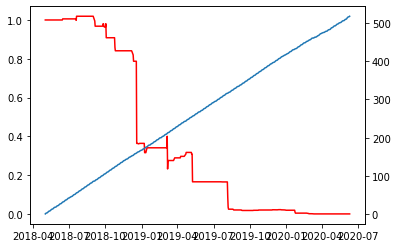

In [7]:
directory = os.fsencode('popularity_export')

def robintrack_strat(limit=100):    
    asset_data = {}
    standard = merge_rh_vol_w_barset('AMZN') # standard barset schema
    returns = pd.DataFrame(1, index=standard.index, columns=['returns','num_assets_traded']) 
    returns['num_assets_traded'] -= 1 
    for filename in os.listdir(directory)[:limit]:
        security = os.fsdecode(filename).replace('.csv','')
        try:
            asset_returns = normalize_merged(standard,merge_rh_vol_w_barset(security))
        except: 
            print('{} data not found'.format(security))
            continue
        returns['returns'] += asset_returns['profit']
        returns['num_assets_traded'] += asset_returns['rh_action']
        if asset_returns['profit'].sum() > 0: 
            print('{} traded, net: {}, num trades: {}'.format(security,asset_returns['profit'].sum(),len(asset_returns[asset_returns['profit'] > 0])))
            
    returns['returns'][returns['num_assets_traded'] > 0] /= returns[returns['num_assets_traded'] > 0]['num_assets_traded']
    returns['cum_returns'] = returns['returns'].cumprod()
    return returns

res = robintrack_strat()
fig,ax = plt.subplots()
ax.plot(res['cum_returns'],color ='red')
ax2 = ax.twinx()
ax2.plot(res['returns'].cumsum())
print(res)
print('cumulative return: {}%, APR: {}%, max_drawdown (approx): {}%, total trades: {}'.format((res['cum_returns'].iloc[-1]-1)*100,(np.sqrt(res['cum_returns'].iloc[-1])-1)*100,(1- res['cum_returns'].min())*100,res['num_assets_traded'].sum()))
plt.show()


154.0


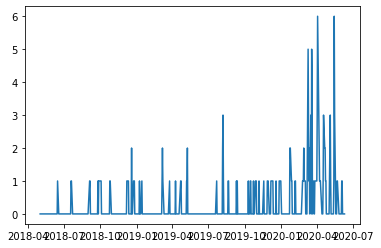

In [4]:
plt.plot(res['num_assets_traded'])
print(res['num_assets_traded'].sum())

In [ ]:
for filename in os.listdir(directory):
    security = os.fsdecode(filename).replace('.csv','')
    try:
        asset_returns = merge_rh_vol_w_barset(security)
        if asset_returns['rh_action'].iloc[-1] == 1:
            print('{} recommendation '.format(security))
            print(asset_returns.iloc[-1])
    except: 
        #print('{} data not found'.format(security))
        pass
print('done')
        

In [ ]:
asset = merge_rh_vol_w_barset('CSCO')
print(asset[asset['rh_action'] == 1])
print(asset['rh_action'].sum())

In [ ]:
api.polygon.historic_agg_v2('PSM',1,'minute',_from= datetime.date.today() - datetime.timedelta(days=5),to=datetime.date.today()).df
print(api.polygon.last_quote('PSM'))